In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
import pandas as pd

cm_df = pd.read_csv('/content/drive/MyDrive/air-quality-prediction/chaingmai-air-quality-v1.csv')
bkk_df = pd.read_csv('/content/drive/MyDrive/air-quality-prediction/bkk-air-quality-v1.csv')

combined_data = pd.concat([bkk_df, cm_df], axis=0).reset_index(drop=True)
combined_data['datetime'] = pd.to_datetime(combined_data['datetime'], format='%d-%m-%Y %H:%M:%S')
combined_data = combined_data.sort_values('datetime')

In [ ]:
combined_data.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
datetime,65070,2022-10-11 08:44:13.941908736,2020-11-25 08:00:00,2021-10-31 05:15:00,2022-10-09 03:00:00,2023-09-20 00:45:00,2024-08-30 10:00:00,NaN
aqi,65070.0,4.169694,1.0,4.0,5.0,5.0,5.0,1.048093
co,65070.0,3650.26206,320.43,1695.63,2696.99,4592.9,34606.93,3070.932508
no,65070.0,53.029614,0.0,3.32,25.93,67.06,987.05,81.217972
no2,65070.0,52.398599,-9999.0,26.73,41.13,63.75,690.94,90.915021
so2,65070.0,40.866441,1.8,12.64,31.95,57.7,392.91,36.428028
o3,65070.0,40.295918,-9999.0,0.0,0.36,31.11,881.2,101.959913
pm2_5,65070.0,89.990272,1.47,37.25,61.45,101.7575,1976.5,106.37457
pm10,65070.0,119.873931,-9999.0,51.56,83.95,138.12,2188.96,142.869989
nh3,65070.0,24.922417,0.0,11.27,22.29,32.42,287.77,18.198361


In [ ]:
combined_data.loc[combined_data['o3'] == -9999.0, 'o3'] = 0.0

combined_data.loc[combined_data['pm10'] == -9999.0, 'pm10'] = 0.0

combined_data.loc[combined_data['no2'] == -9999.0, 'no2'] = 0.0

# The above inplace edits are reflected in the DataFrame.
print(combined_data['o3'].min())
print(combined_data['pm10'].min())
print(combined_data['no2'].min())

0.0
0.0
0.0


In [ ]:
date_time = pd.to_datetime(combined_data.pop('datetime'), format='%Y-%m-%d %H:%M:%S')

In [ ]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [ ]:
day = 24*60*60
year = (365.2425)*day

combined_data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
combined_data['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
combined_data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
combined_data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

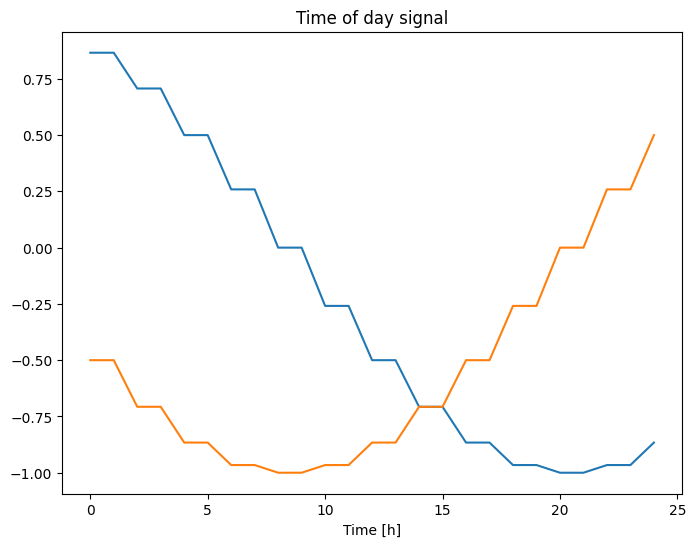

In [ ]:
plt.plot(np.array(combined_data['Day sin'])[:25])
plt.plot(np.array(combined_data['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

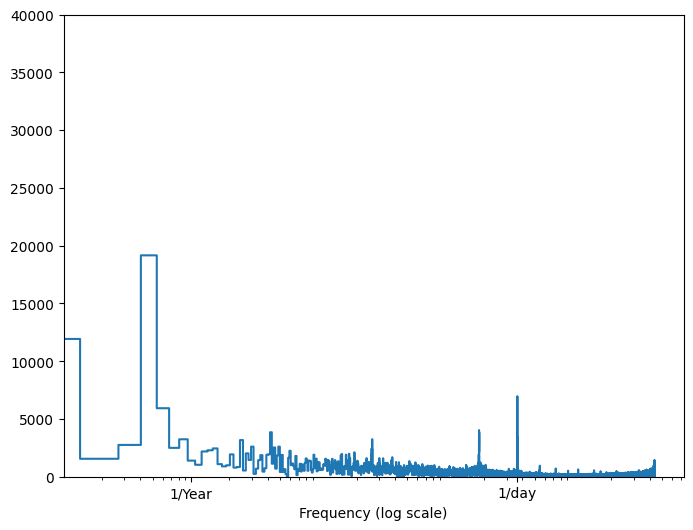

In [ ]:
fft = tf.signal.rfft(combined_data['aqi'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(combined_data['aqi'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 40000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')


In [ ]:
combined_data = pd.get_dummies(combined_data, columns=['city'])

In [ ]:
combined_data.head()

,aqi,co,no,no2,so2,o3,pm2_5,pm10,nh3,Day sin,Day cos,Year sin,Year cos,city_Bangkok,city_Chaing Mai
0,5,3524.78,87.62,52.78,50.55,0.96,71.93,127.34,28.88,0.866025,-0.500000,-0.580944,0.813944,True,False
32523,4,4005.43,74.21,13.54,12.99,0.58,46.81,56.77,11.27,0.866025,-0.500000,-0.580944,0.813944,False,True
32524,5,6462.10,114.44,30.16,13.59,2.84,61.17,72.29,8.36,0.707107,-0.707107,-0.580360,0.814360,False,True
1,5,4272.46,105.50,56.89,58.17,3.13,78.78,147.39,36.99,0.707107,-0.707107,-0.580360,0.814360,True,False
2,5,4165.65,88.51,78.83,72.48,12.88,87.54,174.13,49.65,0.500000,-0.866025,-0.579776,0.814776,True,False


In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(combined_data)

In [ ]:
targets = combined_data['aqi']
combined_data = combined_data.drop(columns=['aqi'])
combined_data.head(5)

,co,no,no2,so2,o3,pm2_5,pm10,nh3,Day sin,Day cos,Year sin,Year cos,city_Bangkok,city_Chaing Mai
0,3524.78,87.62,52.78,50.55,0.96,71.93,127.34,28.88,0.866025,-0.500000,-0.580944,0.813944,True,False
32523,4005.43,74.21,13.54,12.99,0.58,46.81,56.77,11.27,0.866025,-0.500000,-0.580944,0.813944,False,True
32524,6462.10,114.44,30.16,13.59,2.84,61.17,72.29,8.36,0.707107,-0.707107,-0.580360,0.814360,False,True
1,4272.46,105.50,56.89,58.17,3.13,78.78,147.39,36.99,0.707107,-0.707107,-0.580360,0.814360,True,False
2,4165.65,88.51,78.83,72.48,12.88,87.54,174.13,49.65,0.500000,-0.866025,-0.579776,0.814776,True,False


In [ ]:
combined_data.shape

(65070, 14)

In [ ]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 1:])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

LSTM Model

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

scaled_data = np.column_stack((targets.values, X_scaled))

sequence_length = 12
X, y = create_sequences(scaled_data, sequence_length)
y = to_categorical(y - 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

num_classes = y.shape[1]

model = Sequential([
    LSTM(128, activation='relu', return_sequences=True),
    LSTM(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=callbacks)

Epoch 1/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - accuracy: 0.6221 - loss: 0.9035 - val_accuracy: 0.7580 - val_loss: 0.6219
Epoch 2/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 85s 36ms/step - accuracy: 0.7626 - loss: 0.6142 - val_accuracy: 0.7862 - val_loss: 0.5441
Epoch 3/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 78s 33ms/step - accuracy: 0.7900 - loss: 0.5404 - val_accuracy: 0.7815 - val_loss: 0.5399
Epoch 4/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 47s 32ms/step - accuracy: 0.7991 - loss: 0.5060 - val_accuracy: 0.8036 - val_loss: 0.5000
Epoch 5/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 48s 32ms/step - accuracy: 0.8079 - loss: 0.4781 - val_accuracy: 0.8060 - val_loss: 0.4842
Epoch 6/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 47s 32ms/step - accuracy: 0.8133 - loss: 0.4553 - val_accuracy: 0.8149 - val_loss: 0.4585
Epoch 7/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 83s 33ms/step - accuracy: 0.8237 - loss: 0.4341 - val_accuracy: 0.8156 - val_loss: 0.4463
Epoch 8/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 48s 33ms/step - accuracy: 

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Test Loss: 0.43928205966949463, Test Accuracy: 0.8190900683403015


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1) + 1  # Add 1 to convert back to 1-5 range
actual_classes = np.argmax(y_test, axis=1) + 1

print(classification_report(actual_classes, predicted_classes))

204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
              precision    recall  f1-score   support

           1       0.81      0.70      0.75       141
           2       0.65      0.71      0.68       449
           3       0.74      0.74      0.74      1023
           4       0.76      0.68      0.72      1495
           5       0.89      0.92      0.91      3398

    accuracy                           0.82      6506
   macro avg       0.77      0.75      0.76      6506
weighted avg       0.82      0.82      0.82      6506



CNN + LSTM

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

scaled_data = np.column_stack((targets.values, X_scaled))

sequence_length = 6
X, y = create_sequences(scaled_data, sequence_length)
y = to_categorical(y - 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

num_classes = y.shape[1]

model = Sequential([
    Conv1D(filters=128, kernel_size=2, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=callbacks)

Epoch 1/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.6530 - loss: 0.8617 - val_accuracy: 0.7629 - val_loss: 0.6185
Epoch 2/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.7717 - loss: 0.5914 - val_accuracy: 0.7895 - val_loss: 0.5446
Epoch 3/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.7932 - loss: 0.5390 - val_accuracy: 0.7951 - val_loss: 0.5265
Epoch 4/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7984 - loss: 0.5211 - val_accuracy: 0.8009 - val_loss: 0.5133
Epoch 5/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.8053 - loss: 0.4958 - val_accuracy: 0.7985 - val_loss: 0.5129
Epoch 6/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8051 - loss: 0.4896 - val_accuracy: 0.8076 - val_loss: 0.4918
Epoch 7/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8155 - loss: 0.4699 - val_accuracy: 0.8065 - val_loss: 0.4836
Epoch 8/100
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.81

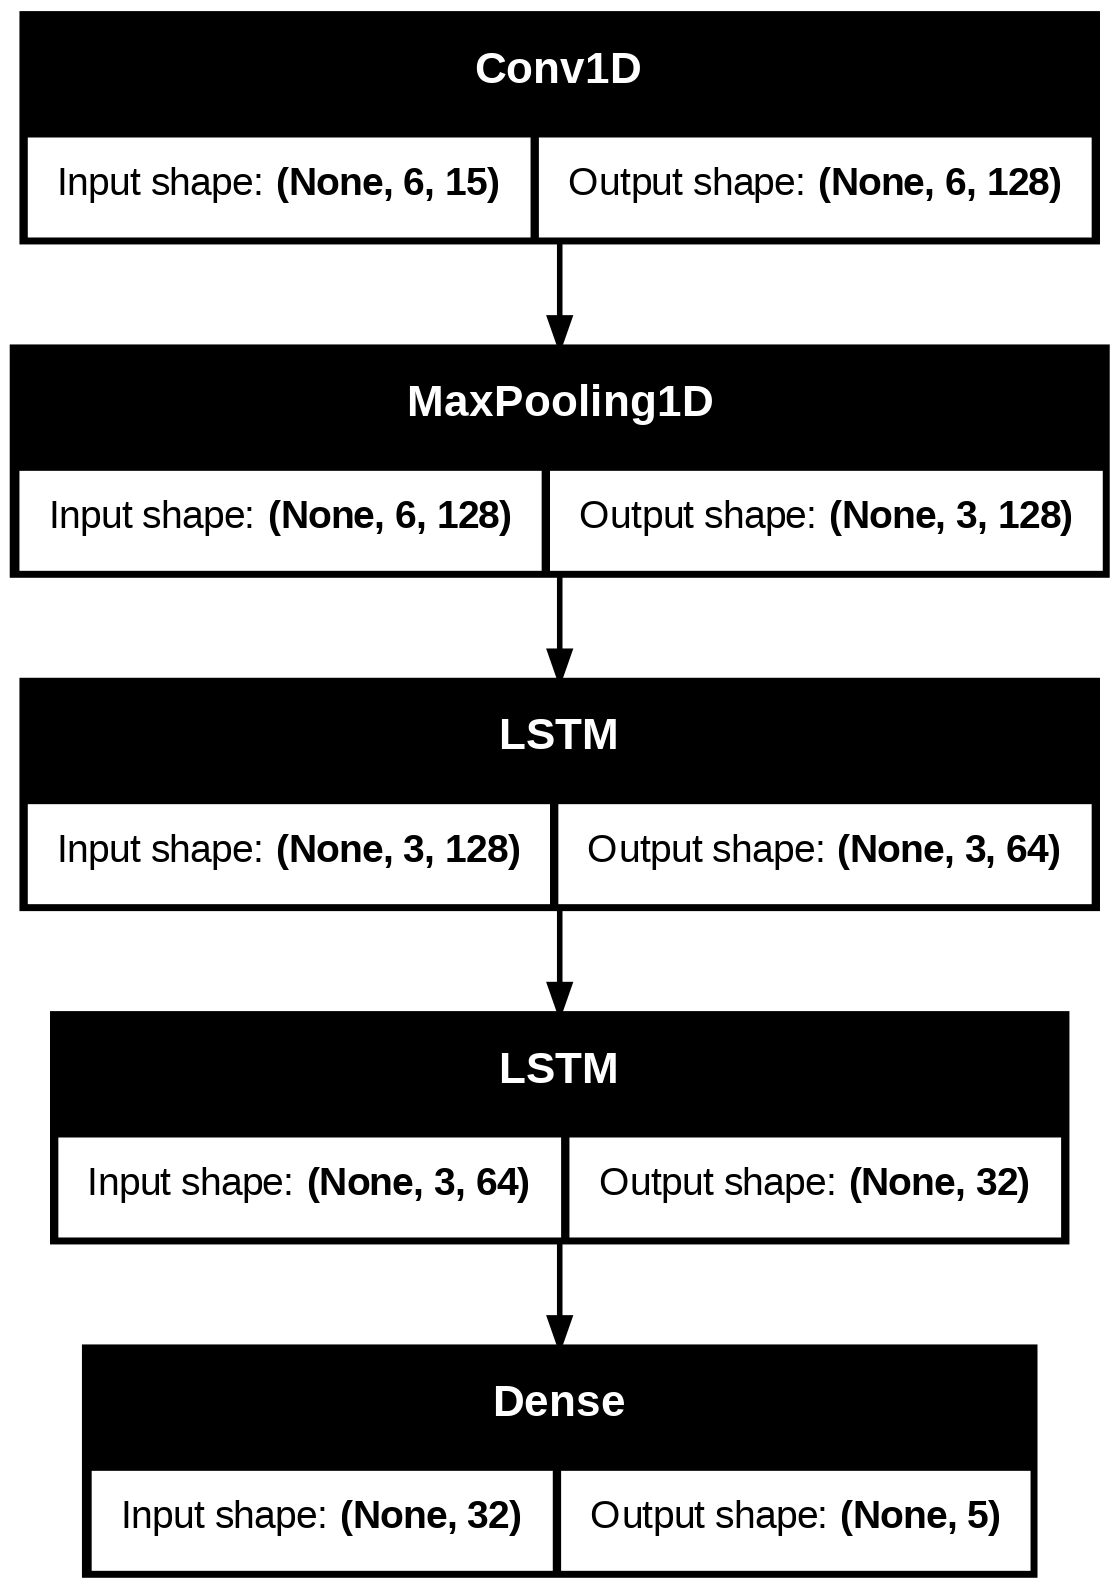

In [ ]:
tf.keras.utils.plot_model(model=model, show_shapes=True)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Test Loss: 0.4841734766960144, Test Accuracy: 0.8105117678642273


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1) + 1  # Add 1 to convert back to 1-5 range
actual_classes = np.argmax(y_test, axis=1) + 1

print(classification_report(actual_classes, predicted_classes))

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           1       0.64      0.74      0.69       112
           2       0.74      0.64      0.69       504
           3       0.74      0.70      0.72       994
           4       0.71      0.70      0.70      1475
           5       0.88      0.92      0.90      3422

    accuracy                           0.81      6507
   macro avg       0.74      0.74      0.74      6507
weighted avg       0.81      0.81      0.81      6507



<Figure size 1000x800 with 0 Axes>

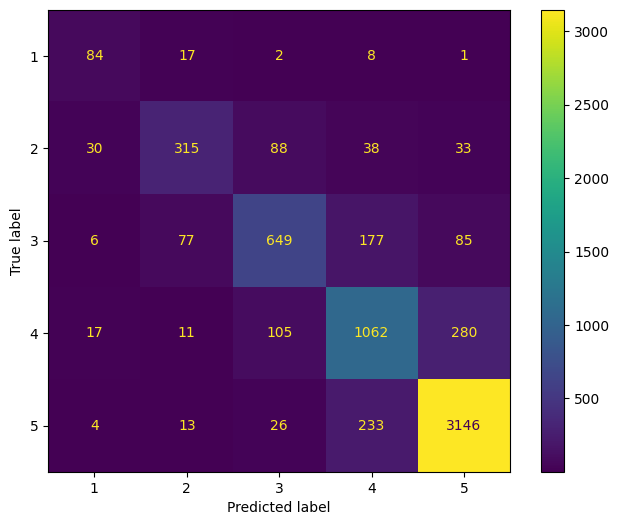

In [ ]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(actual_classes, predicted_classes)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
disp.plot()
plt.show()

Train 70  Test 10 Validation 20

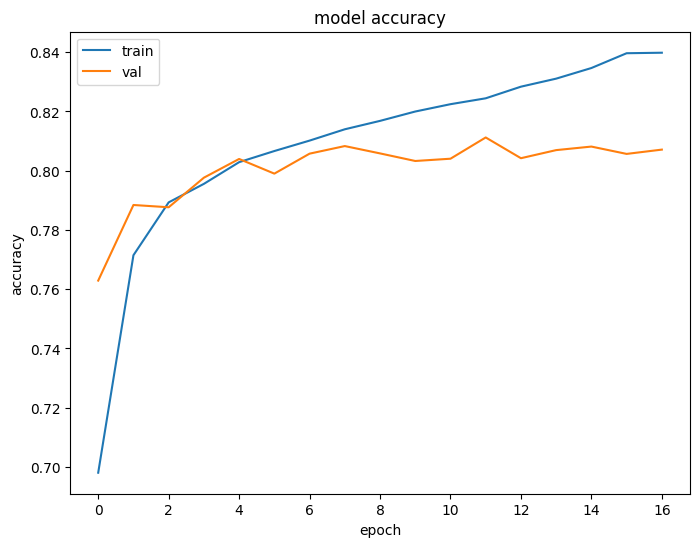

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

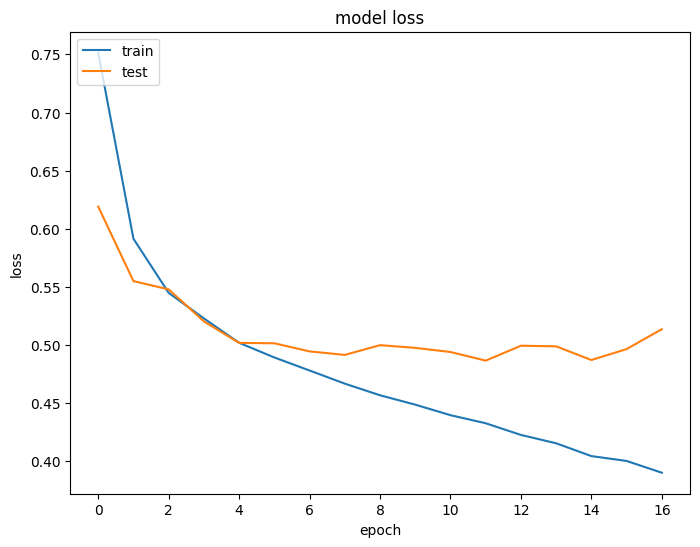

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Test Loss: 0.4942072927951813, Test Accuracy: 0.8077455163002014


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1) + 1  # Add 1 to convert back to 1-5 range
actual_classes = np.argmax(y_test, axis=1) + 1

print(classification_report(actual_classes, predicted_classes))

407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
              precision    recall  f1-score   support

           1       0.68      0.73      0.70       255
           2       0.69      0.64      0.67       929
           3       0.72      0.74      0.73      2050
           4       0.74      0.65      0.69      3010
           5       0.88      0.93      0.90      6768

    accuracy                           0.81     13012
   macro avg       0.74      0.74      0.74     13012
weighted avg       0.81      0.81      0.81     13012



<Figure size 1000x800 with 0 Axes>

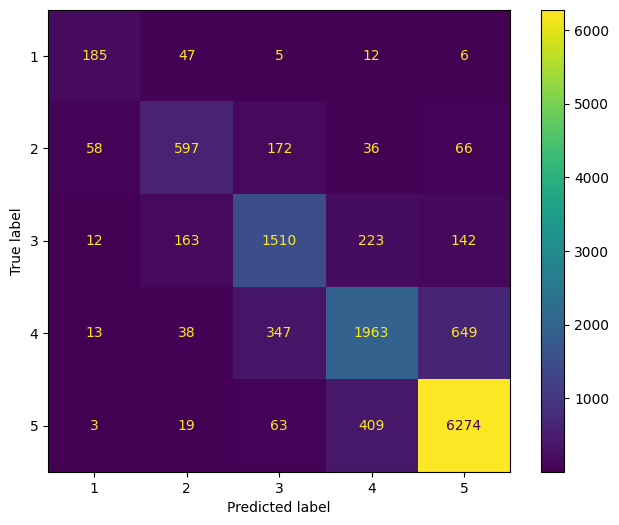

In [ ]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(actual_classes, predicted_classes)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
disp.plot()
plt.show()

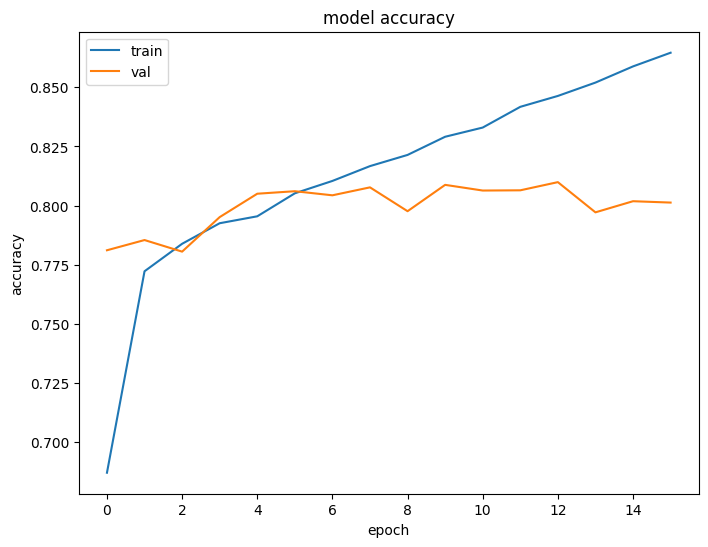

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

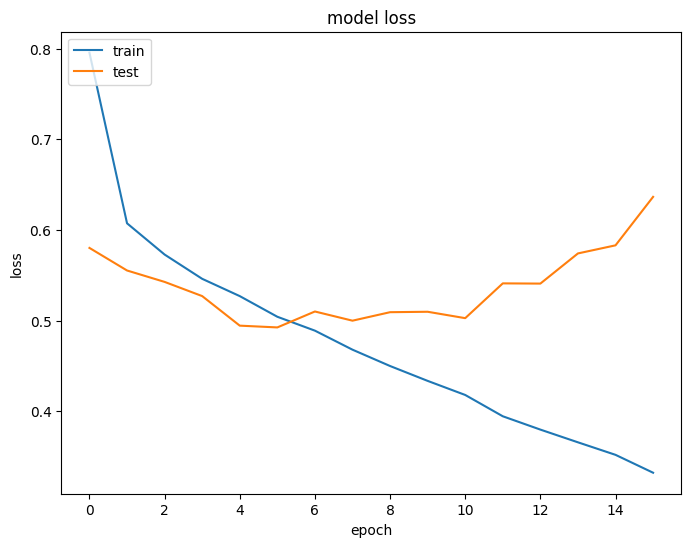

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('cnn_lstm_best_accuracy_aqi_v1.keras')

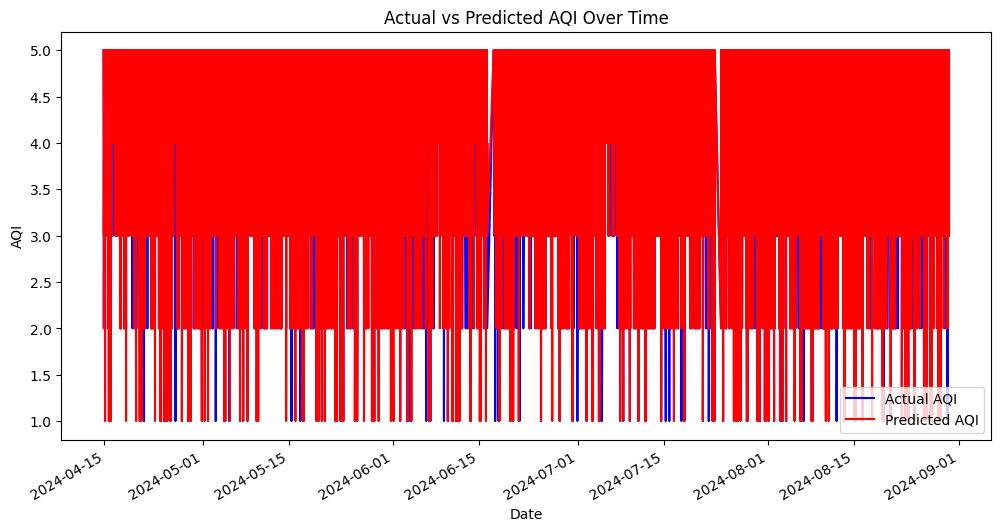

In [ ]:
results_df = pd.DataFrame({
    'datetime': date_time.iloc[-len(actual_classes):].values,
    'true_aqi': actual_classes,
    'predicted_aqi': predicted_classes,
    'city_Bangkok': combined_data['city_Bangkok'].iloc[-len(actual_classes):].values,
    'city_Chaing Mai': combined_data['city_Chaing Mai'].iloc[-len(actual_classes):].values
})

results_df = results_df.sort_values('datetime')

plt.figure(figsize=(12, 6))
plt.plot(results_df['datetime'], results_df['true_aqi'], label='Actual AQI', color='blue')
plt.plot(results_df['datetime'], results_df['predicted_aqi'], label='Predicted AQI', color='red')

plt.title('Actual vs Predicted AQI Over Time')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()

plt.gcf().autofmt_xdate()

plt.show()

In [ ]:
results_df['city'] = results_df.apply(lambda row: 'Bangkok' if row['city_Bangkok'] else 'Chiang Mai', axis=1)

results_df.drop(['city_Bangkok', 'city_Chaing Mai'], axis=1, inplace=True)
results_df.to_csv('cnn_lstm_latest.csv')